In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 2.09344673e+00],
         [ 8.78075719e-01],
         [ 1.89838421e+00],
         ...,
         [ 1.00438678e+00],
         [ 1.61704218e+00],
         [ 7.57595479e-01]],

        [[-1.27024865e+00],
         [-6.73435807e-01],
         [-2.20024252e+00],
         ...,
         [ 1.12722349e+00],
         [-9.36450064e-01],
         [-4.45628650e-02]],

        [[ 1.26073313e+00],
         [ 2.51660973e-01],
         [-6.19307995e-01],
         ...,
         [ 8.86491120e-01],
         [ 2.88815379e-01],
         [ 2.08792019e+00]],

        ...,

        [[ 9.04195547e-01],
         [-1.21696496e+00],
         [ 1.02250469e+00],
         ...,
         [-2.24435687e-01],
         [-7.21710205e-01],
         [ 2.59256989e-01]],

        [[-2.04678249e+00],
         [ 8.33775163e-01],
         [ 4.61836666e-01],
         ...,
         [ 2.24275470e+00],
         [-6.38293624e-02],
         [ 2.58670300e-01]],

      

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

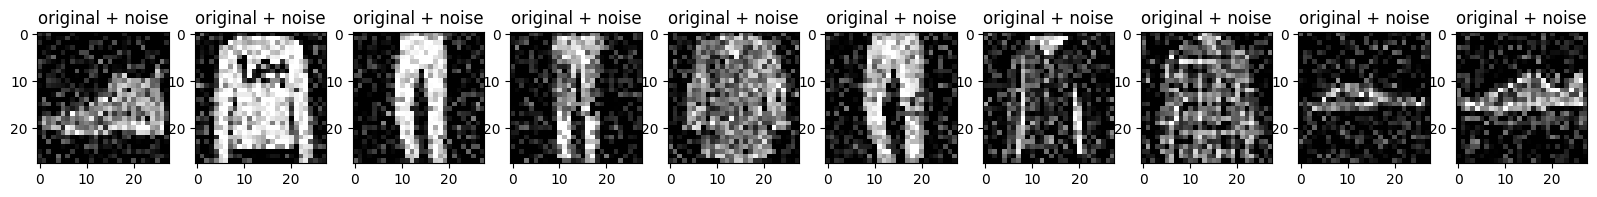

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 42ms/step - loss: 0.0316 - val_loss: 0.0096
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 39ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - loss: 0.0069 - val_loss: 0.0069


In [13]:
autoencoder.encoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
autoencoder.decoder.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

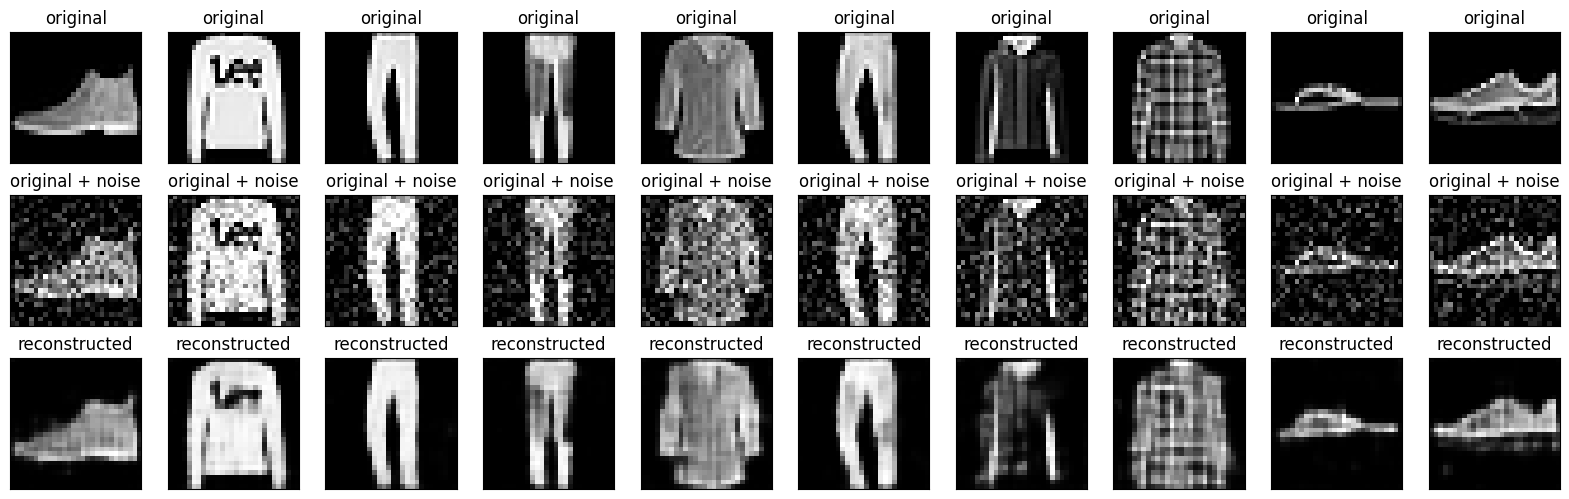

In [16]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [18]:
# Train the CNN-based Denoising Autoencoder with 30 epochs
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=30,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))


Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 74s 313ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 70s 264ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 81s 251ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 252ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 84s 259ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 80s 251ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 251ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 12/30
235/235

In [19]:
# Calculate loss (MSE) for the test dataset
test_predictions = autoencoder.predict(x_test_noisy)
mse_loss = np.mean(np.square(test_predictions - x_test))
print(f'Test Loss (Mean Squared Error): {mse_loss}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Test Loss (Mean Squared Error): 0.006575179751962423


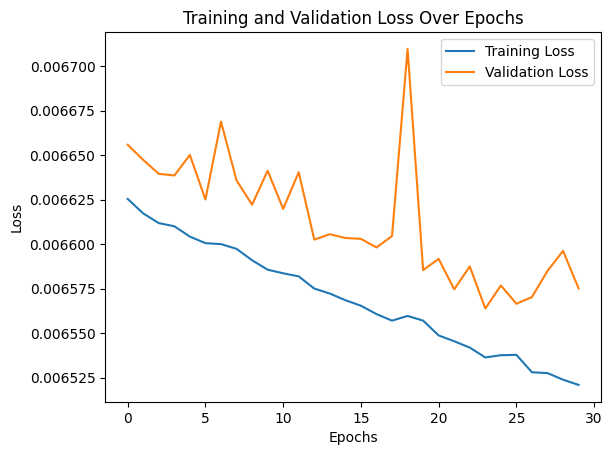

In [20]:
# Plot the train and validation loss against the number of epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Experiment with different noise_factor values (e.g., 0.1, 0.3, 0.5)
noise_factor = 0.3  # Adjust this value to find the best
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Ensure pixel values are within valid range (0, 1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
